In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
!pip install -q tf-models-official==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.4 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
DATA_PATH = os.path.join("/content", 'drive', 'MyDrive', 'Cyberbully', 'cyberbullying_tweets.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.groupby("cyberbullying_type").count()

,tweet_text
cyberbullying_type,
age,7992
ethnicity,7961
gender,7973
not_cyberbullying,7945
other_cyberbullying,7823
religion,7998


In [ ]:

ord = OrdinalEncoder()
df[['cyberbullying_type']] = ord.fit_transform(df[["cyberbullying_type"]])
LABEL_CAT = ord.categories_

In [ ]:
df = df.astype({'cyberbullying_type':'int32', 'tweet_text':'string'})

In [ ]:
print(LABEL_CAT)
df.sample(5)

[array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
       'other_cyberbullying', 'religion'], dtype=object)]


,tweet_text,cyberbullying_type
5946,Vintage bully #onmyblacktieshit,3
27806,My lovely boy #animal #all_shots #beautifulpic...,4
1458,Rebecca Black Left School Because of Bullying:,3
18385,If Allaah has revealed in The Quran over 1400 ...,5
2299,To sofrendo bullying da minha internet,3


In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['tweet_text'])

In [ ]:
@tf.function
def tokenize(tensor):
  return tokenizer.texts_to_sequences(tensor)

In [ ]:
df['tokenized'] = tokenize(df['tweet_text'])

In [ ]:
def pad_list(lst, max_len):
    padded = lst + [0] * (max_len - len(lst))
    return padded

max_len = 300
df['tokenized'] = df['tokenized'].map(lambda x : pad_list(x, max_len))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_tt = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for id_train_val, id_test in strat_tt.split(df[['tokenized', 'tweet_text']], df['cyberbullying_type']):
    df_train_val = df.loc[id_train_val]
    df_test = df.loc[id_test]

df_train_val.reset_index(drop=True, inplace=True)

strat_tv = StratifiedShuffleSplit(n_splits=1, test_size=1/9)
for id_train, id_val in strat_tv.split(df_train_val[['tokenized', 'tweet_text']], df_train_val['cyberbullying_type']):
    df_train = df_train_val.loc[id_train]
    df_val = df_train_val.loc[id_val]

In [ ]:
df["tweet_text"]

0        In other words #katandandre, your food was cra...
1        Why is #aussietv so white? #MKR #theblock #ImA...
2        @XochitlSuckkks a classy whore? Or more red ve...
3        @Jason_Gio meh. :P  thanks for the heads up, b...
4        @RudhoeEnglish This is an ISIS account pretend...
                               ...                        
47687    Black ppl aren't expected to do anything, depe...
47688    Turner did not withhold his disappointment. Tu...
47689    I swear to God. This dumb nigger bitch. I have...
47690    Yea fuck you RT @therealexel: IF YOURE A NIGGE...
47691    Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...
Name: tweet_text, Length: 47692, dtype: string

In [ ]:
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(
    (df_train['tweet_text'].values, df_train['cyberbullying_type'].values)
).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (df_test['tweet_text'].values, df_test['cyberbullying_type'].values)
).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (df_val['tweet_text'].values, df_val['cyberbullying_type'].values)
).batch(BATCH_SIZE)

In [ ]:
for text, label in train_ds:
    print(text)
    print(label.numpy())
    break

tf.Tensor(
[b'That\'s a contradiction in your faith and your leaders which frankly is how your maseeh has changed his views throughout his life. You change color like chameleons. Tomorrow when you are recognized as Muslims by some idiot, you will bring up the "proof" I posted.U can\'t be trusted'
 b'\xe2\x80\x9cThe Fat Girl Behind the Fitness App\xe2\x80\x9d by @naomialderman https://t.co/VGb5Dluy3a'
 b"@Buster_ESPN The Bosox are either trying to bully the Yanks, or they're a little uptight."
 b'@tarkasteve awww. I felt scattered as heck. I need sleep :P'
 b'The last one that u call late at night the first one u dial when u open ur eyes wanna be the one u run to wanna be the one that ain\xe2\x80\x99t gon hurt you I WANNNNNAAAAA BEEEEEE YEAAAAAA'
 b'Quran(9.29) In quran allah clearly orders to kill non-believers untill they convert and collect tax, this is same ISIS terrorist are doing. Force conversion is clearly mention here and you are lying.'
 b'face palm Jesus to the "radical right

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 6)))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
train_token_ds = train_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))
test_token_ds = test_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))
val_token_ds = val_ds.map(lambda x, y: (bert_preprocess(x)['input_word_ids'], y))

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
bert = build_classifier_model()
bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
epochs = 5
init_lr = 1e-5

In [ ]:
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr), loss=loss, metrics=["accuracy"])

In [ ]:
history_bert = bert.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
597/597 [==============================] - 384s 631ms/step - loss: 0.6295 - accuracy: 0.7553 - val_loss: 0.4008 - val_accuracy: 0.8319
Epoch 2/5
597/597 [==============================] - 375s 629ms/step - loss: 0.3911 - accuracy: 0.8396 - val_loss: 0.3585 - val_accuracy: 0.8499
Epoch 3/5
597/597 [==============================] - 378s 633ms/step - loss: 0.3446 - accuracy: 0.8578 - val_loss: 0.3457 - val_accuracy: 0.8581
Epoch 4/5
597/597 [==============================] - 378s 634ms/step - loss: 0.3130 - accuracy: 0.8708 - val_loss: 0.3416 - val_accuracy: 0.8602
Epoch 5/5
597/597 [==============================] - 373s 624ms/step - loss: 0.2876 - accuracy: 0.8804 - val_loss: 0.3373 - val_accuracy: 0.8656


In [ ]:
pred_bert = bert.predict(test_ds)

75/75 [==============================] - 16s 219ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score

def get_top1_top2(pred, ds):
  y_true = []
  for X, y in ds:
      for d in y:
          y_true.append(d.numpy())
  y_true = np.array(y_true)

  y_true_a = np.argmax(y_true, axis=1)
  y_pred_a = np.argmax(pred, axis=1)
  y_second = np.argpartition(pred, -2, axis=1)[:, -2]

  y_pred2_a = np.array([(t if f==t or s==t else f) for t, f, s in zip(y_true_a, y_pred_a, y_second)])
  return [y_true_a, y_pred_a, y_pred2_a]

def plot_cfm_and_summary(y_true, y_pred_1, y_pred_2):
  cf = confusion_matrix(y_true, y_pred_1)
  cf2 = confusion_matrix(y_true, y_pred_2)

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_size_inches(16.5, 4.5)
  ConfusionMatrixDisplay(cf, display_labels=LABEL_CAT[0]).plot(cmap="YlGnBu", ax=axes[0])
  axes[0].set_title("Top 1")
  axes[0].set_xticklabels(LABEL_CAT[0], rotation=45, ha='right')
  ConfusionMatrixDisplay(cf2, display_labels=LABEL_CAT[0]).plot(cmap="YlGnBu", ax=axes[1])
  axes[1].set_title("Top 2")
  axes[1].set_xticklabels(LABEL_CAT[0], rotation=45, ha='right')
  plt.plot()

  print("Top 1")
  print("Accuracy : ", end="")
  print(accuracy_score(y_true, y_pred_1))
  print("F1 Score : ", end="")
  print(f1_score(y_true, y_pred_1, average="macro"))
  print("")
  print("Top 2")
  print("Accuracy : ", end="")
  print(accuracy_score(y_true, y_pred_2))
  print("F1 Score : ", end="")
  print(f1_score(y_true, y_pred_2, average="macro"))
  print("")

Top 1
Accuracy : 0.8536687631027253
F1 Score : 0.8531462746327289

Top 2
Accuracy : 0.9685534591194969
F1 Score : 0.9685092340065612



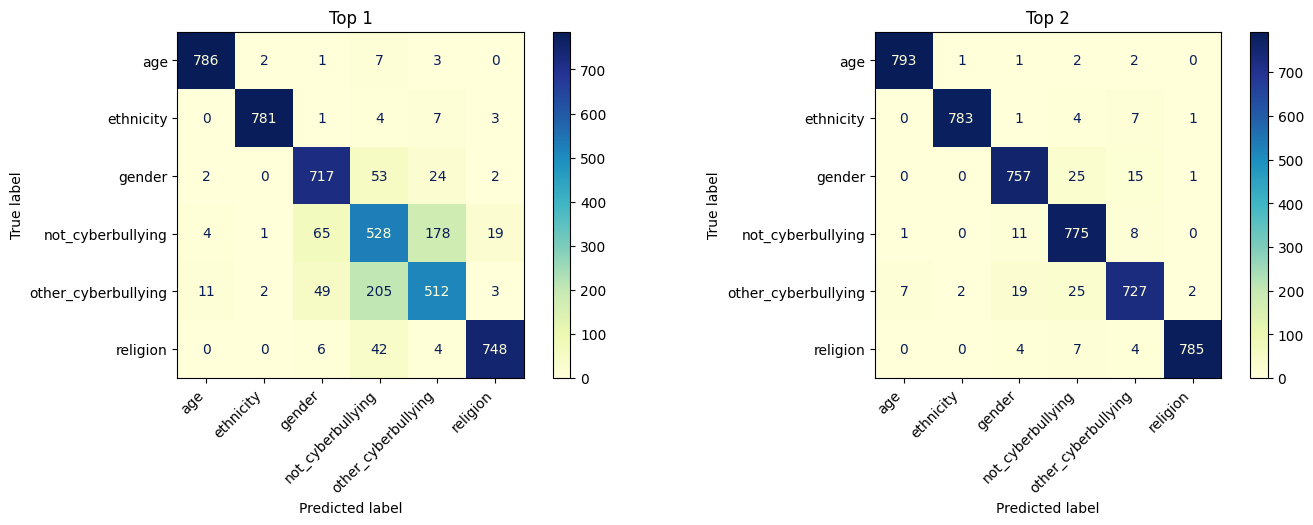

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bert, test_ds))

In [ ]:
bilstm_model = tf.keras.models.Sequential([
    layers.Embedding(30000, 128, input_shape=[128]),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(6, activation='softmax')
])

bilstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 128)          3840000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128, 256)         263168    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128, 512)         1050624   
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              295424    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
history_bilstm = bilstm_model.fit(train_token_ds, validation_data=val_token_ds, epochs=5)

Epoch 1/5
597/597 [==============================] - 99s 166ms/step - loss: 0.6129 - accuracy: 0.7423 - val_loss: 0.4440 - val_accuracy: 0.8107
Epoch 2/5
597/597 [==============================] - 100s 167ms/step - loss: 0.4113 - accuracy: 0.8332 - val_loss: 0.4355 - val_accuracy: 0.8226
Epoch 3/5
597/597 [==============================] - 100s 168ms/step - loss: 0.3303 - accuracy: 0.8729 - val_loss: 0.4563 - val_accuracy: 0.8233
Epoch 4/5
597/597 [==============================] - 104s 175ms/step - loss: 0.2707 - accuracy: 0.8981 - val_loss: 0.4549 - val_accuracy: 0.8298
Epoch 5/5
597/597 [==============================] - 100s 168ms/step - loss: 0.2291 - accuracy: 0.9163 - val_loss: 0.4892 - val_accuracy: 0.8302


In [ ]:
pred_bilstm = bilstm_model.predict(test_token_ds)

75/75 [==============================] - 4s 47ms/step


Top 1
Accuracy : 0.8251572327044026
F1 Score : 0.8171133011000938

Top 2
Accuracy : 0.9524109014675053
F1 Score : 0.952421584294922



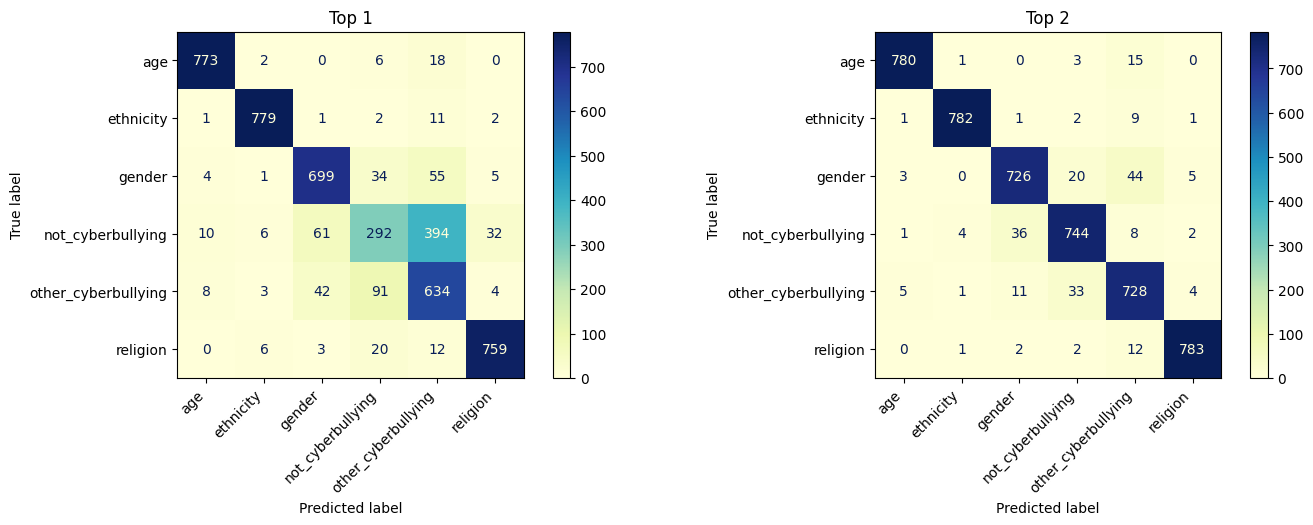

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bilstm, test_token_ds))

In [ ]:
bigru_model = tf.keras.models.Sequential([
    layers.Embedding(30000, 128, input_shape=[128]),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(256, return_sequences=True)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(6, activation='softmax')
])

bigru_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
bigru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         198144    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 512)         789504    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              221952    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                        

In [ ]:
history_bigru = bigru_model.fit(train_token_ds, validation_data=val_token_ds, epochs=5)

Epoch 1/5
597/597 [==============================] - 89s 147ms/step - loss: 0.5983 - accuracy: 0.7442 - val_loss: 0.4082 - val_accuracy: 0.8243
Epoch 2/5
597/597 [==============================] - 89s 149ms/step - loss: 0.3382 - accuracy: 0.8627 - val_loss: 0.4319 - val_accuracy: 0.8314
Epoch 3/5
597/597 [==============================] - 89s 149ms/step - loss: 0.2717 - accuracy: 0.8934 - val_loss: 0.4924 - val_accuracy: 0.8247
Epoch 4/5
597/597 [==============================] - 90s 151ms/step - loss: 0.2298 - accuracy: 0.9111 - val_loss: 0.5591 - val_accuracy: 0.8113
Epoch 5/5
597/597 [==============================] - 89s 149ms/step - loss: 0.1838 - accuracy: 0.9290 - val_loss: 0.5597 - val_accuracy: 0.8138


In [ ]:
pred_bigru = bigru_model.predict(test_token_ds)

75/75 [==============================] - 3s 39ms/step


Top 1
Accuracy : 0.8111111111111111
F1 Score : 0.8113548546232644

Top 2
Accuracy : 0.9465408805031447
F1 Score : 0.9464023263184654



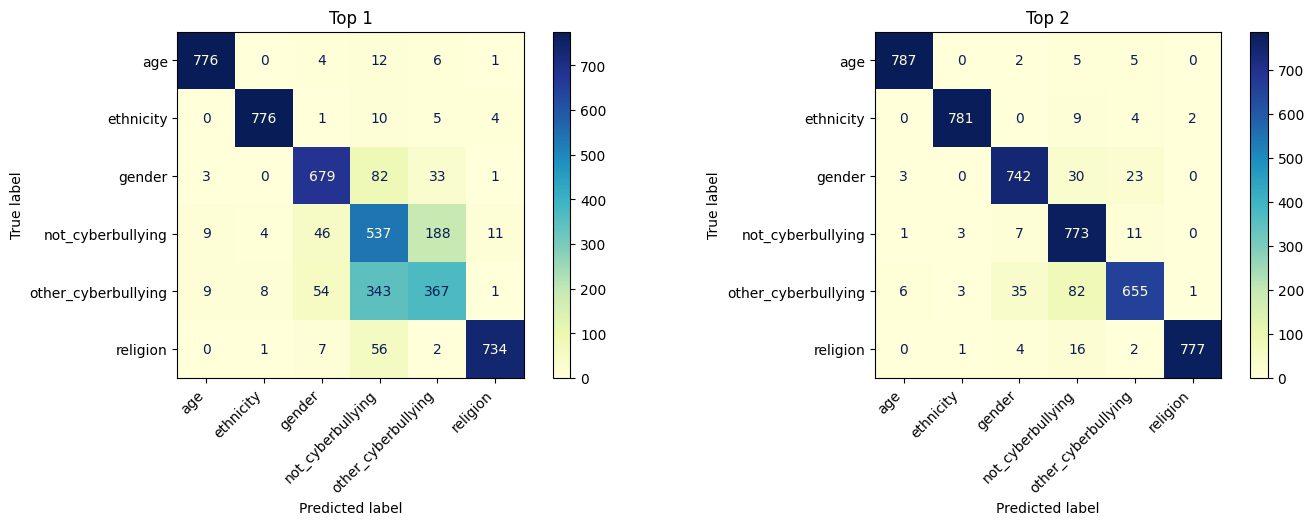

In [ ]:
plot_cfm_and_summary(*get_top1_top2(pred_bigru, test_token_ds))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
model = ['Top 1 BERT', 'Top 2 BERT', 'Top 1 Bi-LSTM', 'Top 2 Bi-LSTM', 'Top 1 Bi-GRU', 'Top 2 Bi-GRU']
scores = ['0.8536687631027253', '0.9685534591194969', '0.8251572327044026', '0.9524109014675053', '0.8111111111111111', '0.9465408805031447']
scores = [float(score) for score in scores]

<Axes: >

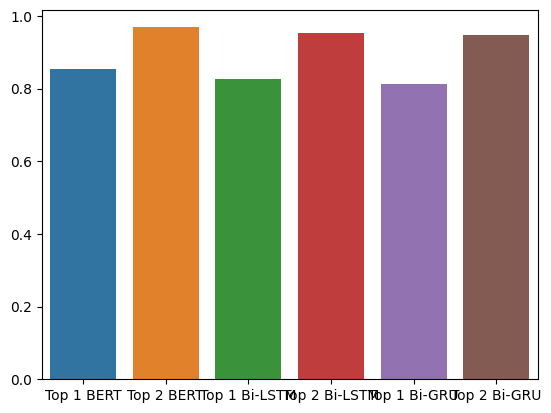

In [ ]:
sns.barplot(x=model, y=scores)

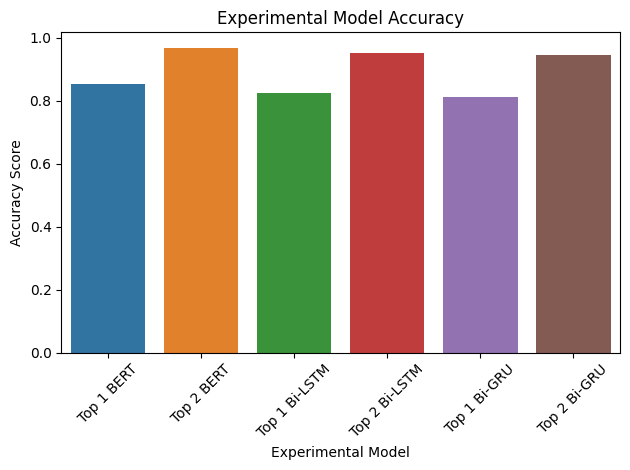

In [ ]:
sns.barplot(x=model, y=scores)
plt.xlabel('Experimental Model')
plt.ylabel('Accuracy Score')
plt.title('Experimental Model Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()